## Single Object - 90367 - Solar Spectrum with Synthetic Fluxes

Here we take best-fit parameters for asteroid (90367) in the case of model 1 and create a set of synthetic fluxes. We modify the solar component of the synthetic fluxes and then re-run fitting. Our goal is to determine exactly how much the best-fit parameters change. 
 

In [1]:
# Repository locations
ATM_DIR = "/epyc/projects/atm/atm/"
ATM_DATA_DIR = "/epyc/projects/atm/atm_data/"

In [2]:
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, 
        context="paper", 
        style="ticks")

%matplotlib inline

import sys
sys.path.append(ATM_DIR)

from atm import modifyErrors
from atm import multiFit
from atm import Config
from atm.models import NEATM
from atm.obs import WISE
from atm.analysis import postProcess
from atm.functions import calcFluxLambdaSED
from atm.functions import calcFluxLambdaObs
from atm.functions import calcFluxLambdaObsWithSunlight
from atm.functions import calcQ
from atm.plotting import plotObservations
from atm.plotting import plotSED

columnMapping = Config.columnMapping

In [3]:
m_to_mum = 1e6 # simple conversion from m to micron
km_to_m = 1e3 # conversion km to m

In [4]:
DPI = 300
SAVE_DIR = "../plots/"
FORMAT = "png"

SAVE_FIGS = False

In [5]:
# Grab observations and additional data
con = sql.connect(os.path.join(ATM_DATA_DIR, "paper1/sample.db"))
observations = pd.read_sql("""SELECT * FROM observations""", con)
additional = pd.read_sql("""SELECT * FROM additional""", con)

# Only keep clipped observations
observations = observations[observations["keep"] == 1]
additional = additional[additional["obs_id"].isin(observations["obs_id"].values)]

# Remove missing H value, G value objects... 
observations = observations[~observations["designation"].isin(['2010 AJ104', '2010 BM69', '2010 DZ64', '2010 EL27', '2010 EW144',
   '2010 FE82', '2010 FJ48', '2010 HK10', '2010 LE80'])]

# Convert phase angle to radians
observations["alpha_rad"] = np.radians(observations["alpha_deg"])
ran_override = False

# Initialize observatory 
obs = WISE()

In [6]:
if ran_override == False:
    observations = modifyErrors(observations, obs, sigma=0.15)
    ran_override = True
else:
    print("No need to run this again!")

Added 0.15 magnitude errors to magErr_W1.
Added 0.15 magnitude errors to magErr_W2.
Added 0.15 magnitude errors to magErr_W3.
Added 0.15 magnitude errors to magErr_W4.
Converted magnitude errors to flux errors.
Updating fluxErr_W1_si with new error.
Updating fluxErr_W2_si with new error.
Updating fluxErr_W3_si with new error.
Updating fluxErr_W4_si with new error.
Done.



## Select asteroid and set sampling configuration

In [7]:
asteroid_name = "90367"

In [8]:
runDict = {}
dataDict = {}

fitConfig = {
        "chains" : 20,
        "samples" : 3000,
        "burnInSamples": 500,
        "threads": 20,
        "scaling": 0.01,
        "plotTrace" : True,
        "plotCorner" : True,
        "progressBar" : True,
        "figKwargs" : {"dpi" : DPI}
    }

data = observations[observations["designation"].isin([asteroid_name])]
data_additional = additional[additional["obs_id"].isin(data["obs_id"].values)] # Contains published magnitudes

In [9]:
data.head()

,obs_id,designation,r_au,delta_au,alpha_deg,H_mag,G,mjd,flux_W1_si,fluxErr_W1_si,...,mag_W1,magErr_W1,mag_W2,magErr_W2,mag_W3,magErr_W3,mag_W4,magErr_W4,keep,alpha_rad
83846,83847,90367,1.163445,0.533788,58.5776,17.7,0.15,55274.190180,1.376464e-10,2.789094e-11,...,14.425,0.220,11.191,0.178,6.302,0.166,4.457,0.198,1,1.022372
83847,83848,90367,1.164340,0.534831,58.5040,17.7,0.15,55274.322484,1.290520e-10,2.710038e-11,...,14.495,0.228,11.293,0.177,6.300,0.166,4.415,0.197,1,1.021087
83848,83849,90367,1.164341,0.534832,58.5040,17.7,0.15,55274.322612,1.540156e-10,3.078224e-11,...,14.303,0.217,11.255,0.180,6.273,0.171,4.488,0.194,1,1.021087
83849,83850,90367,1.165236,0.535876,58.4308,17.7,0.15,55274.454916,1.330347e-10,2.744660e-11,...,14.462,0.224,11.280,0.174,6.299,0.165,4.464,0.200,1,1.019810
83850,83851,90367,1.166130,0.536922,58.3579,17.7,0.15,55274.587220,1.314513e-10,2.615136e-11,...,14.475,0.216,11.348,0.181,6.307,0.167,4.487,0.193,1,1.018537


In [10]:
data_additional.head()

,obs_id,ra_deg,ra_sigma_arcsec,ra_u,dec_deg,dec_sigma_arcsec,dec_u,radec_cosigma_arcsec,w1mpro,w1rchi2,...,w4sigmpro,w4snr,cc_flags,cntr_u,dist_x,pang_x,ph_qual,na,nb,sso_flg
83846,83847,95.653672,0.0883,95.653676,59.797833,0.0861,59.797823,-0.0090,14.425,0.9368,...,0.048,22.4,0000,2,0.035508,-13.268303,AAAA,0,1,1
83847,83848,95.938447,0.0882,95.938555,59.766119,0.0851,59.766032,0.0143,14.495,1.0570,...,0.047,23.0,0000,3,0.369982,-31.848310,AAAA,0,1,1
83848,83849,95.938861,0.0981,95.938817,59.765855,0.1001,59.765942,-0.0275,14.303,1.1080,...,0.044,24.9,0000,4,0.321891,165.586877,AAAA,0,1,1
83849,83850,96.222477,0.0817,96.222457,59.733625,0.0858,59.733641,0.0172,14.462,1.2810,...,0.050,21.6,0000,5,0.067179,147.853468,AAAA,0,1,1
83850,83851,96.504766,0.0883,96.504861,59.700879,0.0927,59.700838,-0.0055,14.475,0.7659,...,0.043,25.1,0000,6,0.227476,-49.544371,AAAA,0,1,1


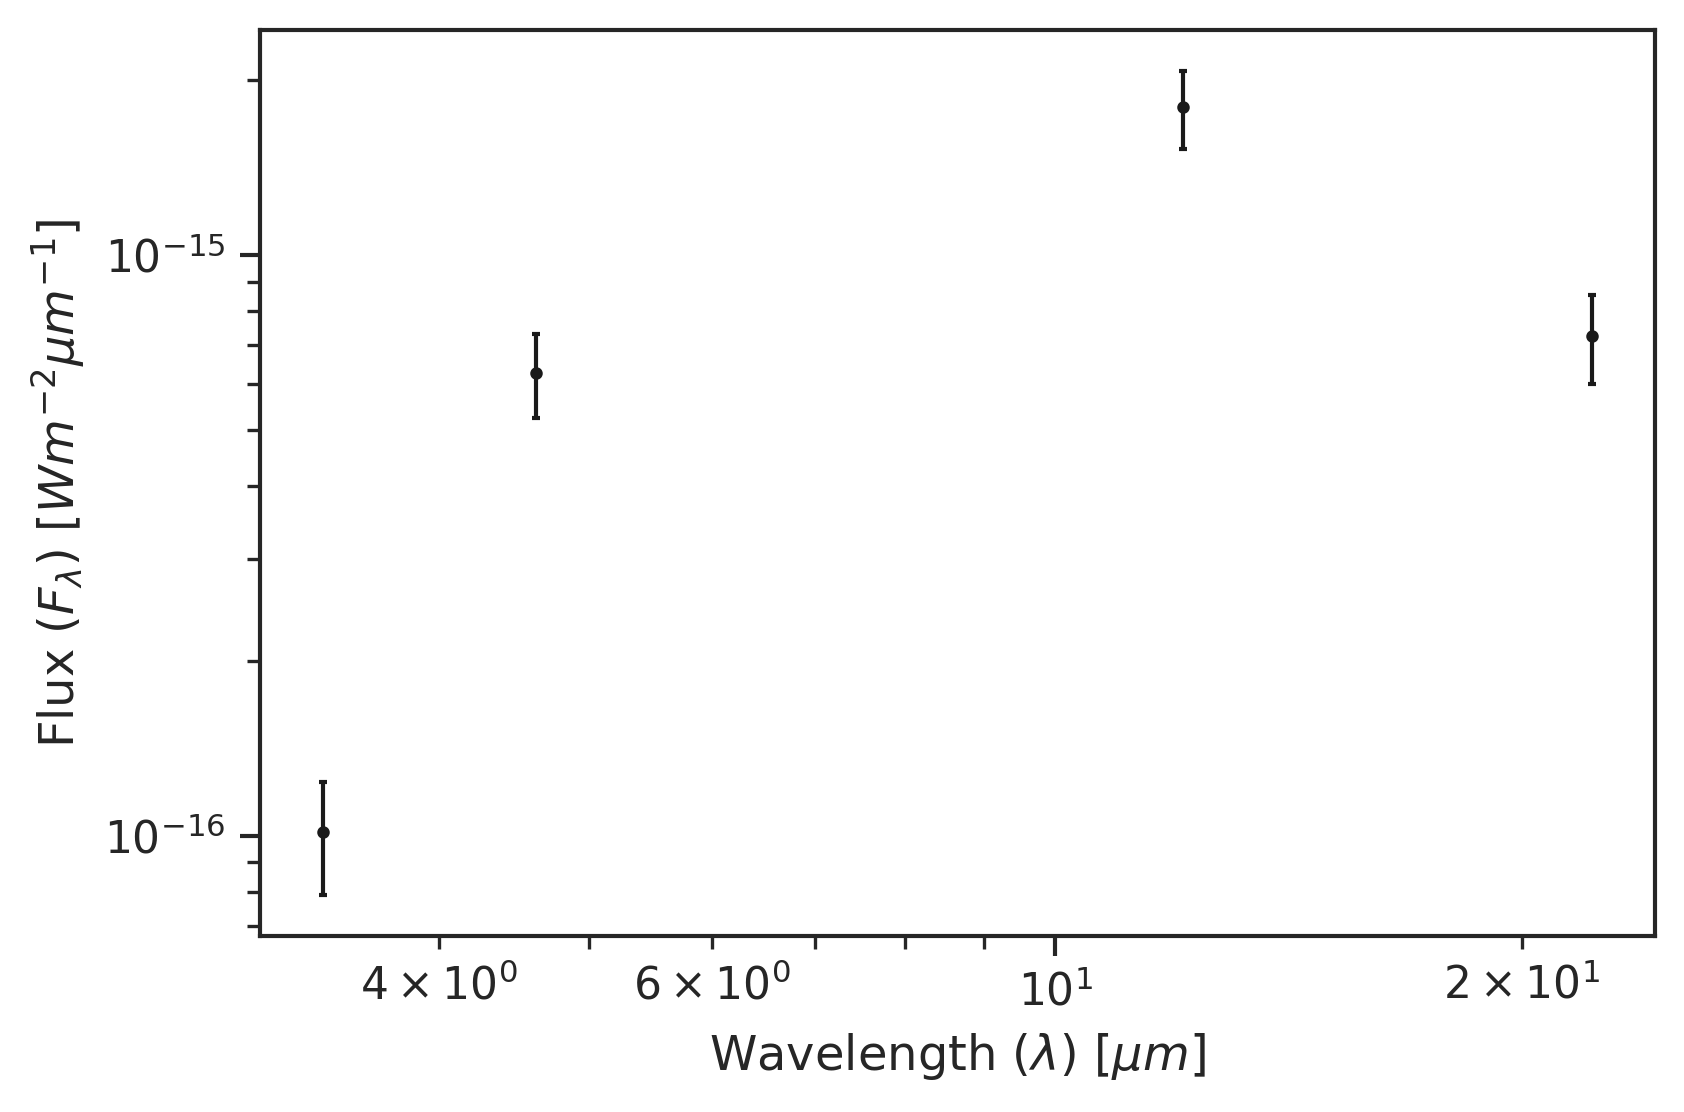

In [11]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
plotObservations(obs, data, ax=ax, plotMedian=True)

## Run 0 - Constant Emissivity
Fit Parameters: [logD, logT1, eps]  
fitFilters = "all"

In [12]:
dataDict["run0"] = data.copy()

runDict["run0"] = {
    "fitParameters" : ["logT1", "logD", "eps"],
    "emissivitySpecification" : None,
    "albedoSpecification": "auto",
    "fitFilters" : "all",
    "columnMapping" : {
                "obs_id" : "obs_id",
                "designation" : "designation",
                "exp_mjd" : "mjd",
                "r_au" : "r_au",
                "delta_au" : "delta_au",
                "alpha_rad" : "alpha_rad",
                "eps" : None,
                "p" : None,
                "G" : "G",
                "logT1" : None,
                "logD" : None,
                "flux_si" : ["flux_W1_si", "flux_W2_si", "flux_W3_si", "flux_W4_si"],
                "fluxErr_si" : ["fluxErr_W1_si", "fluxErr_W2_si", "fluxErr_W3_si", "fluxErr_W4_si"],  
                "mag" : ["mag_W1", "mag_W2", "mag_W3", "mag_W4"],
                "magErr" : ["magErr_W1", "magErr_W2", "magErr_W3", "magErr_W4"]
    }
}

## Run Fits

In [13]:
obs = WISE()
model = NEATM(verbose=False)

summary, model_observations = multiFit(model, obs, dataDict, runDict, fitConfig, 
                                       saveDir=asteroid_name)

Calculating number of fits to run...
Fit code: run0
Found existing results database (90367/run0/atm_results_run0.db).
Objects previously fitted: 1
Removing incomplete fits (sampling may have been interrupted).
Removing incomplete fits (if any) from summary table...
Removing incomplete fits (if any) from model_observations table...
Number of fits to run: 0

Total number of fits to run: 0

No fits to run.


In [14]:
summary

,designation,model,code,parameter,median,sigmaG,mean,sd,mc_error,n_eff,Rhat,hpd_2.5,hpd_97.5
0,90367,NEATM,run0,logT1,2.580088,0.001560,2.580112,0.001574,0.000101,126.874307,1.032926,2.576965,2.582965
1,90367,NEATM,run0,logD,3.230346,0.005489,3.230313,0.005392,0.000338,128.941138,1.035140,3.220203,3.240928
2,90367,NEATM,run0,eps,0.969503,0.005798,0.969772,0.006339,0.000542,107.133867,1.040001,0.957907,0.982988


In [15]:
observations_pp, model_observations_pp, observed_stats, model_stats = postProcess(obs, 
                                                                                  data,
                                                                                  model_observations, 
                                                                                  summary)

Calculating colors using these columns:
Magnitudes : mag_W1, mag_W2, mag_W3, mag_W4
Creating colors: W1-W2, W2-W3, W3-W4
Done.

Calculating model colors using these columns:
Model magnitudes : model_mag_W1, model_mag_W2, model_mag_W3, model_mag_W4
Creating model colors: model_W1-W2, model_W2-W3, model_W3-W4
Done.

Calculating color residuals using these columns:
Observed colors: W1-W2, W2-W3, W3-W4
Model colors : model_W1-W2, model_W2-W3, model_W3-W4
Creating residuals: residual_W1-W2, residual_W2-W3, residual_W3-W4
Done.

Calculating magnitude residuals using these columns:
Observed magnitudes : mag_W1, mag_W2, mag_W3, mag_W4
Model magnitudes : model_mag_W1, model_mag_W2, model_mag_W3, model_mag_W4
Creating residuals: residual_W1, residual_W2, residual_W3, residual_W4
Done.

Calculating chi squared using these columns:
Magnitude residuals : residual_W1, residual_W2, residual_W3, residual_W4
Magnitude errors : magErr_W1, magErr_W2, magErr_W3, magErr_W4
Creating chi2 columns: chi2_W1, c

In [16]:
model_stats[["code", "reduced_chi2"]]

,code,reduced_chi2
0,run0,0.606186


In [17]:
T_ss = 10**summary[summary["parameter"] == "logT1"]["median"].values[0] / np.sqrt(data[columnMapping["r_au"]].values)
D = np.ones(len(T_ss)) * 10**summary[summary["parameter"] == "logD"]["median"].values[0] 
eps = np.ones(len(T_ss)) * summary[summary["parameter"] == "eps"]["median"].values[0]

flux = calcFluxLambdaObs(model, 
                         obs, 
                         data[columnMapping["r_au"]].values, 
                         data[columnMapping["delta_au"]].values,
                         T_ss,
                         D,
                         data[columnMapping["alpha_rad"]].values,
                         eps)

flux_ws = calcFluxLambdaObsWithSunlight(model, 
                         obs, 
                         data[columnMapping["r_au"]].values, 
                         data[columnMapping["delta_au"]].values,
                         T_ss,
                         D,
                         data[columnMapping["alpha_rad"]].values,
                         eps, 
                         (1 - eps) / calcQ(data[columnMapping["G"]].values),
                         data[columnMapping["G"]].values)


In [18]:
# Here we isolate the relflected component, modify it by the ratios of a blackbody flux to that of a more accurate solar spectrum
# and then add the modified reflected component to the original emitted flux
solar_component = flux_ws.T - flux.T
solar_component_mod = np.zeros_like(solar_component)

ratios = [0.981986, 0.897143, 0.847788, 0.814672]

for i in range(4):
    solar_component_mod[:, i] = solar_component[:, i] * ratios[i]
    
fluxes_mod = flux.T + solar_component_mod
mag_mod = obs.convertFluxLambdaToMag(fluxes_mod)

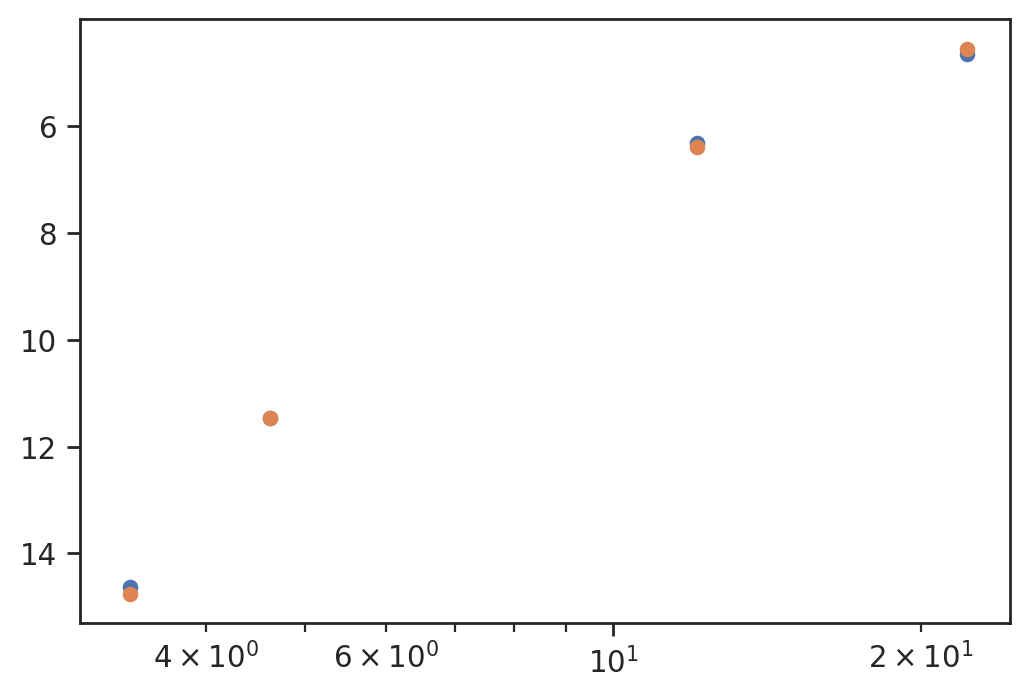

In [19]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(obs.filterEffectiveLambdas * 10**6, np.median(mag_mod, axis=0))
ax.scatter(obs.filterEffectiveLambdas * 10**6, np.median(data[["mag_W1", "mag_W2", "mag_W3", "mag_W4"]].values, axis=0))
ax.invert_yaxis()
ax.set_xscale("log")

In [20]:
data_mod = observations[observations["designation"].isin([asteroid_name])].copy()
data_mod["flux_W1_si"] = fluxes_mod[:, 0]
data_mod["flux_W2_si"] = fluxes_mod[:, 1]
data_mod["flux_W3_si"] = fluxes_mod[:, 2]
data_mod["flux_W4_si"] = fluxes_mod[:, 3]
data_mod["mag_W1"] = mag_mod[:, 0]
data_mod["mag_W2"] = mag_mod[:, 1]
data_mod["mag_W3"] = mag_mod[:, 2]
data_mod["mag_W4"] = mag_mod[:, 3]

dataDict_sp = {}
runDict_sp = {}
dataDict_sp["run0"] = data_mod.copy()

runDict_sp["run0"] = {
    "fitParameters" : ["logT1", "logD", "eps"],
    "emissivitySpecification" : None,
    "albedoSpecification": "auto",
    "fitFilters" : "all",
    "columnMapping" : {
                "obs_id" : "obs_id",
                "designation" : "designation",
                "exp_mjd" : "mjd",
                "r_au" : "r_au",
                "delta_au" : "delta_au",
                "alpha_rad" : "alpha_rad",
                "eps" : None,
                "p" : None,
                "G" : "G",
                "logT1" : None,
                "logD" : None,
                "flux_si" : ["flux_W1_si", "flux_W2_si", "flux_W3_si", "flux_W4_si"],
                "fluxErr_si" : ["fluxErr_W1_si", "fluxErr_W2_si", "fluxErr_W3_si", "fluxErr_W4_si"],  
                "mag" : ["mag_W1", "mag_W2", "mag_W3", "mag_W4"],
                "magErr" : ["magErr_W1", "magErr_W2", "magErr_W3", "magErr_W4"]
    }
}

Calculating number of fits to run...
Fit code: run0
Number of fits to run: 1

Total number of fits to run: 1

Starting fit code: run0

Fitting object 90367 (1/1)...
Fit number: 1/1

Fitting 90367 with NEATM...
Fit Code: run0
Fit Parameters: ['logT1', 'logD', 'eps']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 91
Chains: 20
Samples per Chain: 3500
Burn-in Samples: 500
Effective Samples per Chain: 3000
Threads: 20


Multiprocess sampling (20 chains in 20 jobs)
CompoundStep
>Metropolis: [eps]
>Metropolis: [logT1]
>Metropolis: [logD]
Sampling 20 chains: 100%|██████████| 70000/70000 [00:23<00:00, 2934.80draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


Found best fit parameters:
 logT1: 2.580 +- 0.002
 logD:  3.231 +- 0.006
 eps:   0.967 +- 0.006
Total time: 43.26 seconds
Done.

Completed. Traces have the desired number of samples.
Saving results to database (90367_solar_spectrum/run0/atm_results_run0.db)...
Done.



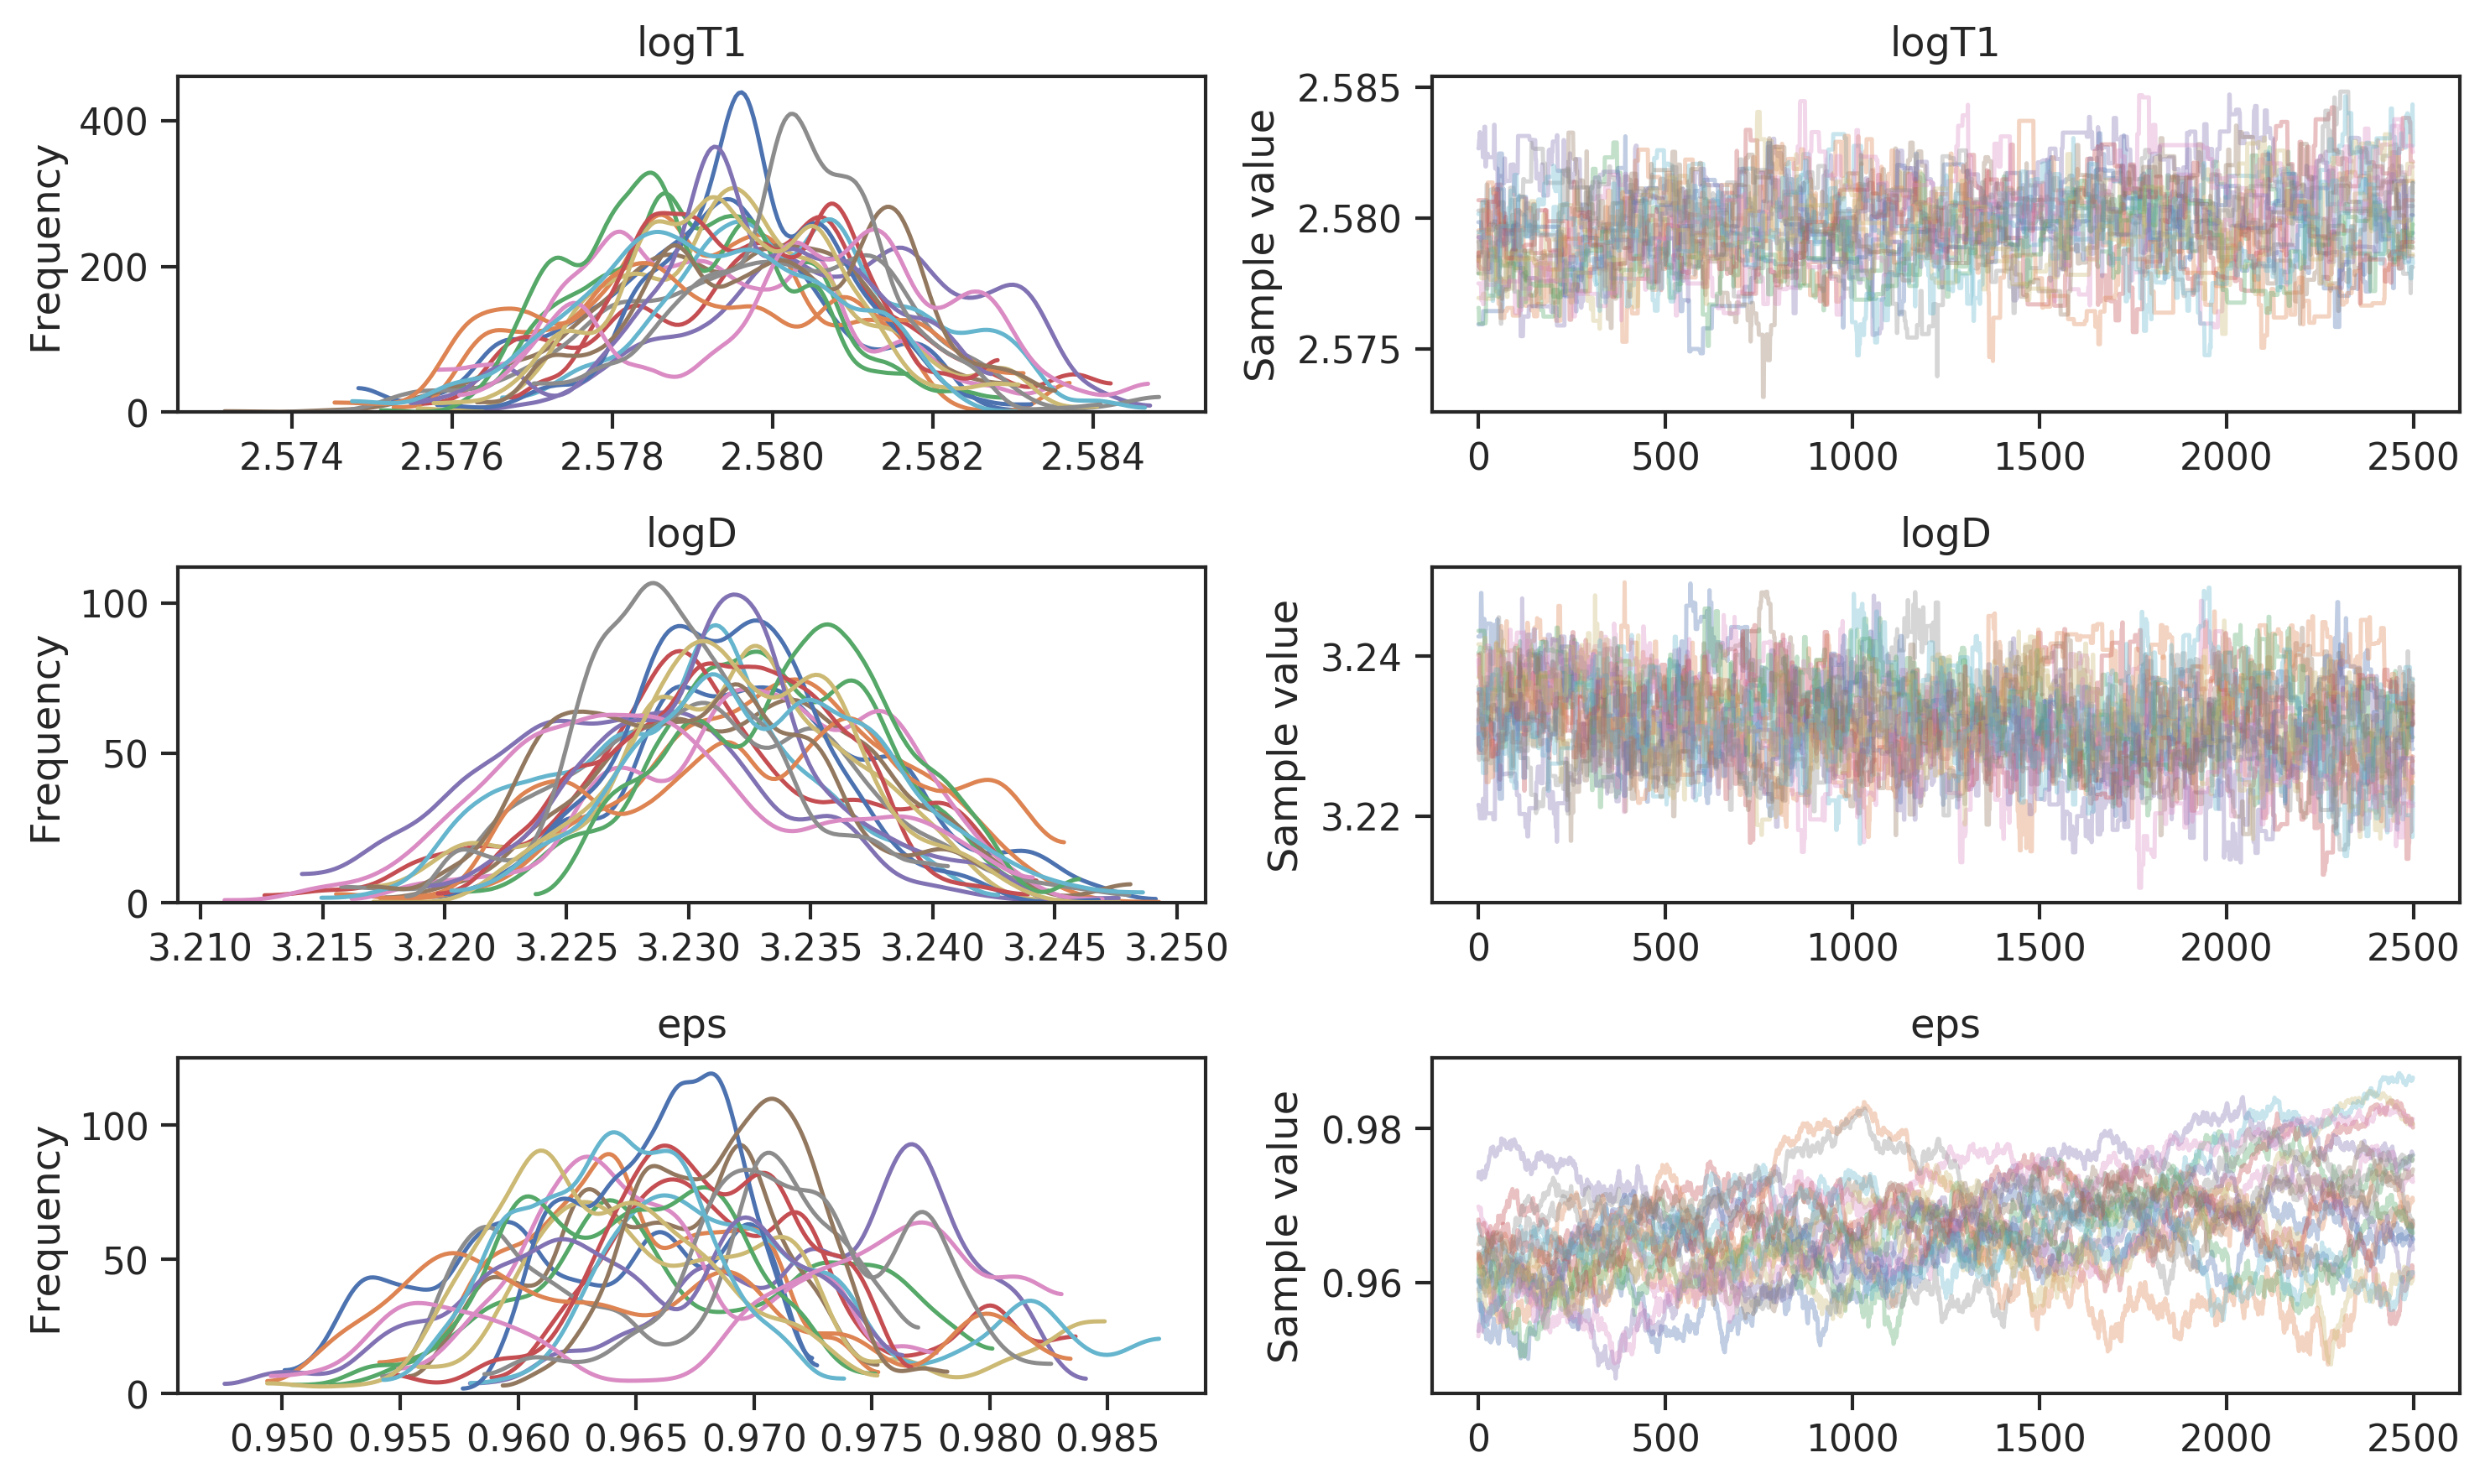

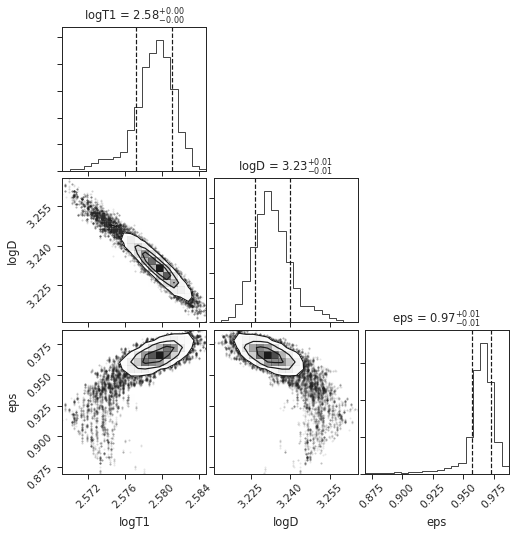

In [21]:
obs = WISE()
model = NEATM(verbose=False)

summary_sp, model_observations_sp = multiFit(model, obs, dataDict_sp, runDict_sp, fitConfig, 
                                             saveDir=asteroid_name + "_solar_spectrum")

In [22]:
summary_sp

,designation,model,code,parameter,median,sigmaG,mean,sd,mc_error,n_eff,Rhat,hpd_2.5,hpd_97.5
0,90367,NEATM,run0,logT1,2.579675,0.001690,2.579654,0.001636,0.000104,141.901512,1.029284,2.576610,2.582862
1,90367,NEATM,run0,logD,3.231491,0.005633,3.231549,0.005553,0.000348,144.410225,1.031225,3.221057,3.242489
2,90367,NEATM,run0,eps,0.966938,0.006486,0.967067,0.006464,0.000553,107.692701,1.035020,0.955122,0.980902


In [23]:
observations_pp_sp, model_observations_pp_sp, observed_stats_sp, model_stats_sp = postProcess(obs, 
                                                                                              data_mod,
                                                                                              model_observations_sp, 
                                                                                              summary_sp)

Calculating colors using these columns:
Magnitudes : mag_W1, mag_W2, mag_W3, mag_W4
Creating colors: W1-W2, W2-W3, W3-W4
Done.

Calculating model colors using these columns:
Model magnitudes : model_mag_W1, model_mag_W2, model_mag_W3, model_mag_W4
Creating model colors: model_W1-W2, model_W2-W3, model_W3-W4
Done.

Calculating color residuals using these columns:
Observed colors: W1-W2, W2-W3, W3-W4
Model colors : model_W1-W2, model_W2-W3, model_W3-W4
Creating residuals: residual_W1-W2, residual_W2-W3, residual_W3-W4
Done.

Calculating magnitude residuals using these columns:
Observed magnitudes : mag_W1, mag_W2, mag_W3, mag_W4
Model magnitudes : model_mag_W1, model_mag_W2, model_mag_W3, model_mag_W4
Creating residuals: residual_W1, residual_W2, residual_W3, residual_W4
Done.

Calculating chi squared using these columns:
Magnitude residuals : residual_W1, residual_W2, residual_W3, residual_W4
Magnitude errors : magErr_W1, magErr_W2, magErr_W3, magErr_W4
Creating chi2 columns: chi2_W1, c

In [24]:
model_stats_sp[["code", "reduced_chi2"]]

,code,reduced_chi2
0,run0,0.000661
